In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [115]:
'''
import os
import shutil 

alist=os.listdir('train')


for i in alist:
    if len(i)-4==5:
        shutil.move('train/'+i, 'train_proc/'+i[:-4]+'XX'+'.png')
    elif len(i)-4==6:
        shutil.move('train/'+i, 'train_proc/'+i[:-4]+'X'+'.png')
    elif len(i)-4==8:
        shutil.move('train/'+i, 'train_proc/'+i[:-5]+'.png')
    elif len(i)-4==7:
        shutil.move('train/'+i, 'train_proc/'+i[:-4]+'.png')
'''

In [3]:
import os
path = Path('train_proc')
os.listdir(path)[:10]

['ablaidX.png',
 'ablcesX.png',
 'ablcher.png',
 'ablches.png',
 'abldedX.png',
 'ablersX.png',
 'ablight.png',
 'ablignX.png',
 'abliler.png',
 'ablkers.png']

In [29]:
#labels = [[char for char in code.name[:-4]] for code in (path).glob('*.png')]
#labels = set([letter for label in labels for letter in label])
#print(len(labels), 'different labels were found')

In [49]:
labels = [[char for char in code.name[:-4]] for code in (path).glob('*.png')]
labels = set([letter for label in labels for letter in label])
labels=list(labels)
labels.sort()
print(len(labels), 'different labels were found')

33 different labels were found


In [50]:
encoding_dict = {l:e for e,l in enumerate(labels)}
decoding_dict = {e:l for l,e in encoding_dict.items()}

code_dimension = len(labels)
captcha_dimension = 7

In [51]:
encoding_dict

{'-': 0,
 'A': 1,
 'F': 2,
 'M': 3,
 'P': 4,
 'S': 5,
 'X': 6,
 'a': 7,
 'b': 8,
 'c': 9,
 'd': 10,
 'e': 11,
 'f': 12,
 'g': 13,
 'h': 14,
 'i': 15,
 'j': 16,
 'k': 17,
 'l': 18,
 'm': 19,
 'n': 20,
 'o': 21,
 'p': 22,
 'q': 23,
 'r': 24,
 's': 25,
 't': 26,
 'u': 27,
 'v': 28,
 'w': 29,
 'x': 30,
 'y': 31,
 'z': 32}

In [52]:
def to_onehot(filename):
    code = filename.name[:-4]
    onehot = np.zeros((code_dimension, captcha_dimension))
    for column, letter in enumerate(code):
        onehot[encoding_dict[letter], column] = 1
    return onehot.reshape(-1)

def to_idx(filename):
    code = filename.name[:-4]
    return np.array([encoding_dict[c] for c in code])#, dtype=torch.long)

def decode(onehot):
    onehot = onehot.reshape(code_dimension, captcha_dimension)
    idx = np.argmax(onehot, axis=0)
    return [decoding_dict[i.item()] for i in idx]

def label_accuracy(preds, actuals):
    pred = torch.unbind(preds)
    act = torch.unbind(actuals)
    
    valid = 0
    total = 0
    
    for left,right in zip(pred,act):
        total+=1
        p = decode(left)
        a = decode(right)
        if p==a: valid += 1

    return torch.tensor(valid/total).cuda()

def char_accuracy(n):
    def c_acc(preds, actuals):
        pred = torch.unbind(preds)
        act = torch.unbind(actuals)

        valid = 0
        total = 0

        for left,right in zip(pred,act):
            total+=1
            p = decode(left)
            a = decode(right)
            if p[n]==a[n]: valid += 1

        return torch.tensor(valid/total).cuda()
    return c_acc

In [53]:
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2,42)
        .label_from_func(to_onehot, label_cls = FloatList) #making it a regression instead of classification (because this gave better results)
        .transform(size=(77,247))
        .databunch(bs=64))
        #.normalize(imagenet_stats))

In [9]:
#data.batchsize=64

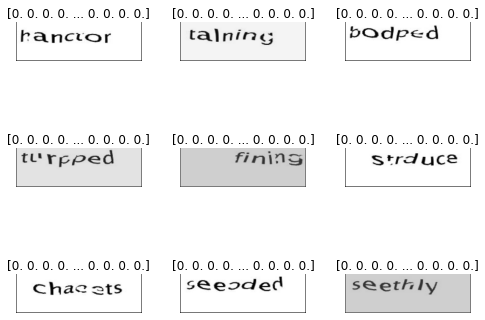

In [54]:
data.show_batch(rows=3, figsize=(7,6))

In [55]:
path=Path('')

In [56]:
learn = cnn_learner(data, models.resnet50, model_dir='models',pretrained=False,path=Path(''),
                    metrics=[label_accuracy, char_accuracy(0),char_accuracy(1),char_accuracy(2),char_accuracy(3),char_accuracy(4),char_accuracy(5),char_accuracy(6)],
                   ps=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


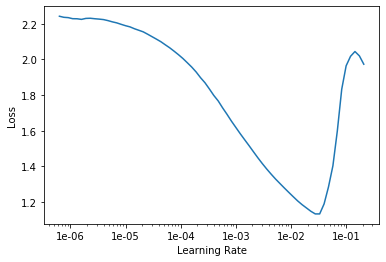

In [12]:
lr_find(learn)
learn.recorder.plot()

In [13]:
# Next cell showed an error. https://forums.fast.ai/t/lesson-2-amazon-planet-cant-create-numpy-are-from-cuda-tensor/28380/7

# Got away with it by : 
# I went to the fastai code in the last file mentioned in the error(tensor.py) and replaced self.numpy() with self.cpu().numpy(). Your calls will automatically access this change.

# /home/sarwari/anaconda/envs/fastai/lib/python3.6/site-packages/torch/tensor.py This file was changed.

'''Changed 
def __array__(self, dtype=None):
        if dtype is None:
            return self.numpy()
        else:
            return self.numpy().astype(dtype, copy=False)
            
To

def __array__(self, dtype=None):
        if dtype is None:
            return self.cpu().numpy()
        else:
            return self.cpu().numpy().astype(dtype, copy=False)
            
'''

'Changed \ndef __array__(self, dtype=None):\n        if dtype is None:\n            return self.numpy()\n        else:\n            return self.numpy().astype(dtype, copy=False)\n            \nTo\n\ndef __array__(self, dtype=None):\n        if dtype is None:\n            return self.cpu().numpy()\n        else:\n            return self.cpu().numpy().astype(dtype, copy=False)\n            \n'

In [11]:
#test
lr=5e-3
learn.fit_one_cycle(70,max_lr=lr,wd=0.01)

epoch,train_loss,valid_loss,label_accuracy,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,c_acc,time
0,0.471645,0.049751,0.000000,0.033097,0.015366,0.015366,0.010638,0.055556,0.042553,0.016548,00:50
1,0.309311,0.038337,0.000000,0.046099,0.087470,0.069740,0.047281,0.256501,0.130024,0.417258,00:39
2,0.259510,0.034381,0.000000,0.065012,0.176123,0.069740,0.061466,0.273050,0.160756,0.481087,00:39
3,0.235198,0.033746,0.000000,0.053191,0.176123,0.069740,0.087470,0.360520,0.190307,0.472813,00:39
4,0.214857,0.040724,0.000000,0.079196,0.100473,0.075650,0.083924,0.293144,0.173759,0.471631,00:39
5,0.195005,0.042869,0.000000,0.074468,0.174941,0.098109,0.044917,0.281324,0.179669,0.465721,00:39
6,0.172232,0.035978,0.000000,0.070922,0.133570,0.086288,0.079196,0.343972,0.189125,0.508274,00:39
7,0.148940,0.036801,0.000000,0.041371,0.132388,0.042553,0.054374,0.378251,0.196217,0.518913,00:39
8,0.125103,0.039044,0.000000,0.092199,0.111111,0.050827,0.066194,0.385343,0.215130,0.495272,00:39
9,0.103979,0.041519,0.000000,0.050827,0.192671,0.104019,0.060284,0.353428,0.178487,0.539007,00:39


In [57]:
path

WindowsPath('.')

In [ ]:
#learn.save('stage-1',return_path=True)

In [58]:
learn.load('stage-1');

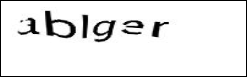

In [59]:
img = open_image('test/ablger.png')
img

In [60]:
defaults.device = torch.device('cpu')
pred_class,pred_idx,outputs = learn.predict(img)

In [61]:
decode(pred_idx)

['a', 'b', 'l', 'g', 'e', 'r', 'X']

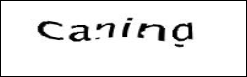

In [62]:
img = open_image('test/caning.png')
img

In [63]:
defaults.device = torch.device('cpu')
pred_class,pred_idx,outputs = learn.predict(img)

In [64]:
decode(pred_idx)

['c', 'a', 'n', 'i', 'n', 'g', 'X']